# Подготовка данных и обучение нейронных сетей:

In [4]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import torch, torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
import torchvision.utils as vutils
from torchvision import transforms, models
import cv2
from bs4 import BeautifulSoup
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
from torch.utils.tensorboard import SummaryWriter
%matplotlib inline
import shutil

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

## Реализуем обучение нейронной сети, выполняющей детектирование объектов класса "person"

Имеется заранее размеченный датасет. Закачать можно по этой [ссылке](https://disk.yandex.ru/d/7HNoc81at3r6VQ)

Реализуем аугментацию данных, увеличив датасет вдвое. Для этого написал кастомную функцию aug:

In [3]:
from augmentation import *
#aug(out_folder='augmented_dataset')

___

### Преподготовка данных для обучения сети Faster RCNN:

Разделим данные на тренировочные и тестовые:

In [4]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('augmented_dataset/images'):
    names.append(file.split('.')[0])

Рандомно поделим фотографии на train (80%) и test (20%)

In [5]:
train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на train = 800
Число изображений на test = 200


В файле data_analysis.ipynb мы поработали с данными в формате json. Теперь рассмотрим как работать работать с аналогичными данными, но представленными в формате xml

In [6]:
with open('detect_dataset/annotations/PASCAL_VOC_xml/oz7_violation_frame519.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
print(objects)

[<object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1000.3</xmin>
<ymin>301.6</ymin>
<xmax>1082.3</xmax>
<ymax>514.5</ymax>
</bndbox>
</object>, <object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1140.9</xmin>
<ymin>260.36</ymin>
<xmax>1215.6</xmax>
<ymax>493.2</ymax>
</bndbox>
</object>]


В данном случае информативная информация представлена в разделе _xmin_, _ymin_, _xmax_, _ymax_ и сам класс представлен в разделе _name_

In [7]:
# Создадим функции, которые как раз распарсят эти данные:
def generate_box(obj):
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    return [xmin, ymin, xmax, ymax]

'''
класс человек - 1
p.s:
    Я заранее прописал условия номеров классов
    для обучении следующей сети с двумя классами:
      1 -  человек с каской
      2 -  человек без каски
'''
def generate_label(obj):
    if (obj.find('name').text == "person") or (obj.find('name').text == "hat"):
        return 1
    elif obj.find('name').text == "no_hat":
        return 2   
    return 0

Pytorch как раз при обучении для моделей детекции тредует данные в формате [xmin, ymin, xmax, ymax] для каждого бокса

In [8]:
'''
Эта функция будет выдавать на выходе словарь с 3 ключами: boxes, labels и image_id.
На вход функция принимает:
image_id - индекс фотки из Dataset класса Pytorch 
file - путь к xml файлу
'''
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)

        # Будем итерироваться по листу, полученному после раскрытия xml файла:
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # В данном случае всего 1 класс 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # переведем индекс торч тензор
        img_id = torch.tensor([image_id])

        # получим итоговый словарь для исследуемой фотографии
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [9]:
class MakeDataset(Dataset):
    def __init__(self, path, data, transforms=None):
        self.transforms = transforms
        self.names_list = data
        self.path = path

    def __getitem__(self, idx):
        name = self.names_list[idx]
        file_image = self.path + '/images/' + str(name) + '.jpg'
        file_label = self.path + '/annotations/' + str(name) + '.xml'
        img = Image.open(file_image).convert("RGB")

        #Сделаем словарь с аннотацией с помощью ранее написанной функции:
        target = generate_target(idx, file_label)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.names_list)

In [10]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

# На вход класса MakeDataset в __init__ подается значение списка файлов и 
# путь общей папке с аннотациями и изображениями:

train_dataset = MakeDataset(path='augmented_dataset', data=train_data, transforms=data_transform)
val_dataset = MakeDataset(path='augmented_dataset', data=test_data, transforms=data_transform)

Посмотрим в каком формате данные харнятся в классе Датасет:

In [11]:
first = train_dataset[6]
features, labels = first
print(labels)

{'boxes': tensor([[ 915.,  371., 1064.,  761.]]), 'labels': tensor([1]), 'image_id': tensor([6])}


В данном случае на фотке есть 2 объекта класса человек, поэтому 2 bounding бокса

In [20]:
def collate_fn(batch):  # Представляет значения в батчах как кортежи
    return tuple(zip(*batch)) 


batch_size = 4  # Зададим чило фотографий на 1 батч

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)

val_data_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Демонстрация выходных данных в класса DataLoader

In [21]:
device = 'cpu'
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[808., 473., 967., 831.]]), 'labels': tensor([1]), 'image_id': tensor([514])}, {'boxes': tensor([[1079.,  381., 1187.,  787.],
        [1010.,  470., 1143.,  857.]]), 'labels': tensor([1, 1]), 'image_id': tensor([203])}, {'boxes': tensor([[ 923.,  470., 1106.,  992.]]), 'labels': tensor([1]), 'image_id': tensor([504])}, {'boxes': tensor([[ 852.,  374.,  993.,  722.],
        [ 995.,  364., 1100.,  731.]]), 'labels': tensor([1, 1]), 'image_id': tensor([267])}]


---

### Визуализируем исходные изображения: 

Возьмем случайные 2 фотки и изобразим их боксы:


In [ ]:
image_batch, label_batch = next(iter(train_data_loader))

# Пройдемся в цикле по двум первым фоткам в рандомном батче:
for i, image in enumerate(image_batch[0:2]):
    image = np.transpose(image, (1, 2, 0))
    img = image.numpy().copy() 
    img = (img * 255).astype(np.uint8)
    annot = label_batch[i]

    # Зададим наименования классов:
    class_detect = ['none','person']

    # Зададим цветовое отображение для классов:
    color_class = [(0,0,255), (0,255,0), (255,50,0)]

    # Пройдемся в цикле по всем боксам на изображении
    for j in range(annot['boxes'].size()[0]):
            [xmin, ymin, xmax, ymax] = annot['boxes'][j]
            xmin = int(xmin)
            ymin = int(ymin)
            xmax = int(xmax)
            ymax = int(ymax)
            n_class = int(annot['labels'][j])
            text = class_detect[n_class] 
            img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color_class[n_class], 2)
            img = cv2.putText(img, text, (xmin, ymin - 15),
                                cv2.FONT_HERSHEY_SIMPLEX, 2, color_class[n_class], 3)
    plt.imshow(img)
    plt.show()

: 

: 

---

Будем использовать Transfer learning подход, обучая сеть Faster RCNN, которая была уже предобучена на COCO

In [22]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Заменим число выходных класссов на то, что нам нужно
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Зададим модель (число классов задал как n+1, так как пустой 0 класс)
model = get_model_instance_segmentation(2)

### Обучение сети:

Внутри реализации Faster R-CNN с FPN (Feature Pyramid Network) в библиотеке PyTorch torchvision используется сложная функция потерь, которая объединяет несколько подфункций.


In [23]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Будем обучать сети на видеокарте:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

#device = 'cpu'
model.to(device)
num_epochs = 40  # число эпох обучения

cpu


В данном случае выбор оптимизатора SGD может быть обусловлен следующими причинами:

Размер и сложность модели: Faster R-CNN с ResNet50-FPN — это достаточно большая и сложная модель с множеством обучаемых параметров, что может привести к быстрому переобучению и нестабильности при использовании более сложных оптимизаторов, таких как Adam.
Количество и тип данных: при обучении объектных детекторов, основанных на Faster R-CNN, используется функция потерь, которая состоит из нескольких компонентов, включая компоненты, связанные с классификацией и регрессией объектов. SGD является классическим оптимизатором, который хорошо справляется с обучением таких моделей, в то время как Adam, который является более продвинутым методом, может не давать оптимальных результатов.
Наличие предобученных весов: в данном случае мы используем предобученные веса для Faster R-CNN с ResNet50-FPN, что может упростить процесс обучения и позволить использовать более простой оптимизатор SGD вместо Adam.

In [24]:
# Создадим пустую папку, в которую будем сохранять обученные модели
newpath = 'models'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [18]:
# Запустим прямо в ноутбуке TensorBoard:
%reload_ext tensorboard
%tensorboard --logdir 'runs'

loss_dict представляет словарь, который содержит значения функции потерь для каждой из компонентов Faster R-CNN, используемых во время обучения. В частности, словарь loss_dict в модели Faster R-CNN включает следующие компоненты функции потерь:

1. Loss_objectness отвечает за определение, содержит ли регион предполагаемого объекта какой-либо объект или нет (бинарная классификация). Для этого loss_objectness использует бинарную кросс-энтропию между выходом сети и соответствующими метками для каждого региона.

2. Loss_classifier отвечает за определение, к какому классу принадлежит объект в данном регионе. Для этого loss_classifier использует многоклассовую кросс-энтропию между выходом сети и соответствующими метками классов для каждого региона.
3. Loss_box_reg отвечает за определение насколько хорошо модель прогнозирует корректные координаты ограничивающего прямоугольника (bounding box) для обнаруженного объекта на изображении. Для этого loss_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

4. Loss_rpn_box_reg отвечает за определение насколько хорошо модель прогнозирует координаты ограничивающего прямоугольника (bounding box) для регионов, полученных от Region Proposal Network (RPN), которые могут содержать объекты. Для этого loss_rpn_box_reg использует среднеквадратичную ошибку между прогнозируемыми координатами ограничивающего прямоугольника и фактическими координатами.

### Код обучения сети:

In [25]:
# Инициализация Tensorboard
writer = SummaryWriter(comment = ' Human_detection')

# Задал значение стартового наивысщего лосса валидации:
best_loss = float('inf') 

# Цикл по эпохам обучения:
for epoch in range(num_epochs):
    
    print(f'Идет обучение {epoch+1} эпохи (из {num_epochs})')   

    # Будем считать суммарную ошибку на эпохе, поэтому первоначально занулим лоссы
    epoch_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0

    # Переведем модель в режим обучения и начнем итераыии по батчам
    model.train()
    for i, (images, targets) in tqdm(enumerate(train_data_loader)):
        
        # Стопаю итерацию по батчам после 25 спусков. Из-за suffle=True фотки каждый раз новые
        # Благодаря этому мы сможем чаще оценивать loss валидации 
        if i == 25:
            break

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Получим словарь со значниями loss функций :
        loss_dict = model(images, targets)       

        # Найдем суммарный loss и сделаем шаг град. спуска:
        losses = sum(loss for loss in loss_dict.values())       
        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 

        # Используем для подсчета всехсредних лоссов за эпоху:
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item()
        epoch_loss += losses

    # Запишем в TensorBoard значения лоссов на трейне:    
    writer.add_scalar('Summ train loss during epochs', epoch_loss/i, epoch+1)
    writer.add_scalar('Train loss_classifier', loss_classifier/i, epoch+1)
    writer.add_scalar('Train loss_box_reg', loss_box_reg/i, epoch+1)
    writer.add_scalar('Train loss_objectness', loss_objectness/i, epoch+1)
    writer.add_scalar('Train loss_rpn_box_reg', loss_rpn_box_reg/i, epoch+1)

    print(f'Train summ loss after {epoch+1} epochs = {epoch_loss/i}')

    # Обнулим суммарный лосс валидации
    val_total_loss = 0
    # Перевод модели в режим валидации для оценки суммарного лосса на вал. датасете
    with torch.no_grad():
        for images, targets in tqdm(val_data_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets) 

            # Вычислим лосс на батче
            losses = sum(loss for loss in loss_dict.values())        
            val_total_loss += losses.item()

        # Запишем в TensorBoard значение суммарного лосса на валидации:
        writer.add_scalar('Summ validation loss during epochs',
                          val_total_loss/len(val_data_loader) , epoch+1)
        print(f'Validation summ loss after {epoch+1} epochs = {val_total_loss/len(val_data_loader)}')

    '''
    Если на валидации мы получили меньше лосс чем текущий best_loss, то сохраняем веса модели
    Тем самым мы на выходе получим модель, имеющую самый низкий лосс на валидации, 
    из всех обученных нами эпох
    '''
    if val_total_loss/len(val_data_loader) < best_loss:
        state_dict = model.state_dict()
        print('Сохраним новую модель, так как текущая конфигурация имеет ниже val loss')
        best_loss = val_total_loss/len(val_data_loader)
        torch.save(state_dict, 'models/model_human_detection.pth')
        
# Закрытие Tensorboard
writer.close()   

Идет обучение 1 эпохи (из 40)


25it [36:42, 88.10s/it] 


train summ loss after 1 epochs = 0.345551073551178


100%|██████████| 50/50 [25:41<00:00, 30.83s/it]


Validation summ loss after 1 epochs = 0.18863370165228843
Сохраним новую модель, так как текущая конфигурация имеет ниже val loss
Идет обучение 2 эпохи (из 40)


11it [14:55, 79.36s/it]

Загрузка самого успешного состояния модели:

In [46]:
model = get_model_instance_segmentation(2)
model.load_state_dict(torch.load('models/model_human_detection.pth'))

<All keys matched successfully>

---

тестирование:

In [3]:
from predict import *
detect_and_visualize(image_input='detect_dataset/images/am3_7_violation_frame142.jpg', classes=['person'], plt_show=False)

c:\Program Files (x86)\Arduino\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files (x86)\Arduino\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Объектов класса person обнаружено 1


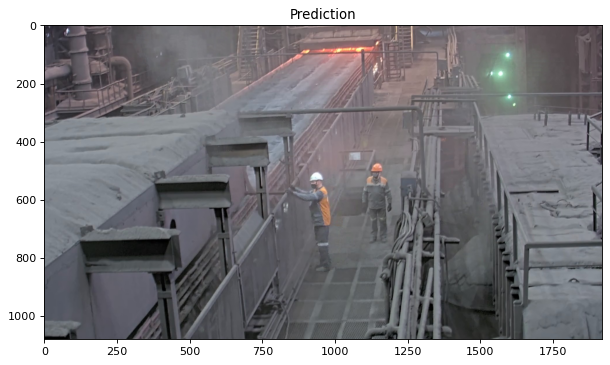

In [1]:
from PIL import Image 
from  matplotlib import pyplot as plt
file_image = 'detect_dataset\images\oz7_violation_frame498.jpg'
image = Image.open(file_image).convert("RGB")
plt.figure(figsize=(9, 7), dpi=80)
plt.title(f'Prediction')
plt.imshow(image)
plt.show()
    

In [15]:
name = test_data[12]  # Взяли фотку с теста
file_image = 'augmented_dataset/images/' + str(name) + '.jpg'
image = Image.open(file_image).convert("RGB")
test_im = data_transform(image)
device = 'cpu'
test_im = test_im[ None, :, :, :]
print(test_im.size())

torch.Size([1, 3, 1080, 1920])


In [16]:
model = model.to(device)
model.eval()
with torch.no_grad():
    preds = model(test_im)
print(preds)

[{'boxes': tensor([[ 728.4958,  213.5045,  764.2094,  259.7223],
        [ 716.9158,  197.8254,  769.2668,  271.3576],
        [ 723.1696,  190.7163,  751.8546,  251.4628],
        [ 739.5417,  190.8153,  765.3412,  258.1391],
        [ 722.2820,  229.2909,  768.1446,  283.6917],
        [ 737.2021,  230.2848,  763.5924,  264.9203],
        [ 720.2897,  209.1976,  749.8693,  288.8727],
        [ 695.4041,  190.0727,  769.3415,  296.4543],
        [ 743.9470,  223.0480,  769.2274,  270.9832],
        [ 571.6551,  165.4066,  627.0245,  235.6716],
        [ 744.6705,  220.4452,  775.5914,  253.0870],
        [ 715.5301,  172.0306,  751.2354,  228.9783],
        [ 748.5699,  211.3569,  790.3383,  265.2649],
        [ 729.3192,  165.5235,  767.5104,  208.2189],
        [ 719.0078,  197.9938,  761.0037,  334.4930],
        [ 473.9755,  178.2271,  659.3376,  237.0885],
        [ 747.1430,  242.9357,  771.5836,  271.2579],
        [ 740.7446,  246.7722,  764.3783,  276.9828],
        [ 559.632

In [17]:

test_im = test_im[0].to(device)
test_im = np.transpose(test_im,(1,2,0))
print(test_im.size())
test_im = test_im.numpy()
print(preds)

torch.Size([1080, 1920, 3])
[{'boxes': tensor([[ 728.4958,  213.5045,  764.2094,  259.7223],
        [ 716.9158,  197.8254,  769.2668,  271.3576],
        [ 723.1696,  190.7163,  751.8546,  251.4628],
        [ 739.5417,  190.8153,  765.3412,  258.1391],
        [ 722.2820,  229.2909,  768.1446,  283.6917],
        [ 737.2021,  230.2848,  763.5924,  264.9203],
        [ 720.2897,  209.1976,  749.8693,  288.8727],
        [ 695.4041,  190.0727,  769.3415,  296.4543],
        [ 743.9470,  223.0480,  769.2274,  270.9832],
        [ 571.6551,  165.4066,  627.0245,  235.6716],
        [ 744.6705,  220.4452,  775.5914,  253.0870],
        [ 715.5301,  172.0306,  751.2354,  228.9783],
        [ 748.5699,  211.3569,  790.3383,  265.2649],
        [ 729.3192,  165.5235,  767.5104,  208.2189],
        [ 719.0078,  197.9938,  761.0037,  334.4930],
        [ 473.9755,  178.2271,  659.3376,  237.0885],
        [ 747.1430,  242.9357,  771.5836,  271.2579],
        [ 740.7446,  246.7722,  764.3783,  

In [18]:
# Реализация построения результата детекции тестовой картинки
treshhold = 0.1  # Задалим порог. Если score больше порога, то выделяем бокс
plt.figure(figsize=(9, 7), dpi=80)
plt.title(f'test_image')
image = (test_im.copy() * 255).astype(np.uint8)
class_detect = ['none','person']

for i in range(preds[0]['boxes'].size()[0]):
        if float(preds[0]['scores'][i]) > treshhold:
                [xmin, ymin, xmax, ymax] = preds[0]['boxes'][i]
                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                text = class_detect[int(preds[0]['labels'][i])] + ' ' + \
                  str(round(float(preds[0]['scores'][i]),2))
                image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                image = cv2.putText(image, text, (xmin, ymin - 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
plt.imshow(image)
plt.show()

: 

: 

---

## Детекция людей с каской с без:

С помощью вэб сервиса https://www.makesense.ai/ я самостоятельно разметил часть изображений, сделав на этот раз 2 отдельных класса - __человек с каской на голове__ и __человек без каски__. <br>
Датасет, содержащий новую аннотацию можно скачать по этой [ссылке](https://disk.yandex.ru/d/9fph4DZZbUc1bQ) <br>
Результирующие аннотации я сохранил в папке detect_hat_dataset/annotations <br><br>

Теперь добавим в пока еще пустую папку detect_hat_dataset/images изображения, соответсвующие данным аннотациям (отберем по совпадающему названию)

In [16]:
# Получим имена файлов аннотаций нового датасета без значения кодировки
names = []
for file in os.listdir('detect_hat_dataset/annotations'):
    names.append(file.split('.')[0])
print(f'Всего вручную размеченных фотографий {len(names)} штук')

Всего вручную размеченных фотографий 128 штук


Скопируем из папки detect_dataset/images подходящие фотки в папку detect_hat_dataset/images:

In [23]:
for file in os.listdir('detect_dataset/images'):
    if file.split('.')[0] in names:
        shutil.copy2('detect_dataset/images/' + file, 'detect_hat_dataset/images')

Так как в данном случае изображений размеченных особенно мало, поэтому воспользуемся готовой функцией аугментации для увеличения размера датасета в 2 раза:

In [25]:
'''
aug(image_dir="detect_hat_dataset/images",
                  xml_dir="detect_hat_dataset/annotations",
                  out_folder='augmented_hat_dataset')
'''

Исходное число фотографий и аннотаций = 128
Итоговое число фотографий и аннотаций = 256


Теперь у нас есть папка augmented_hat_dataset с которой мы и будем работать при обучении сети